In [31]:
# Copyright 2025 The LEVER Authors - All rights reserved.
# SPDX-License-Identifier: Apache-2.0

"""
Global visualization setup for publication-quality figures.
Defines color palette, style settings, and shared helper functions.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rcParams


# ============================================================================
# Style Configuration
# ============================================================================

# Accessible, high-contrast palette
PALETTE = {
    'baseline':   '#E29578',  # Coral (FCI/Exact/Reference)
    'primary':    '#264653',  # Charcoal (Main Method/Variational)
    'secondary':  '#2A9D8F',  # Teal (Optimization/sCI)
    'accent':     '#457B9D',  # Slate Blue (Auxiliary/Chem Acc)
    'bar_fill':   '#E9ECEF',  # Light Gray (Background bars)
    'bar_edge':   '#6C757D',  # Slate Gray (Bar outlines)
    'grid':       '#E5E5E5',  # Subtle Grid
    'text':       '#333333'   # Dark Gray Text
}

def set_publication_style():
    """Apply global matplotlib settings for clean, academic aesthetics."""
    rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
        'font.size': 11,
        'axes.linewidth': 1.2,
        'axes.edgecolor': PALETTE['text'],
        'axes.labelcolor': PALETTE['text'],
        'axes.spines.top': False,
        'axes.spines.right': False,
        'xtick.color': PALETTE['text'],
        'ytick.color': PALETTE['text'],
        'text.color': PALETTE['text'],
        'figure.dpi': 300,
        'grid.color': PALETTE['grid'],
        'grid.linestyle': '--',
        'grid.alpha': 0.7,
        'legend.frameon': False,
        'legend.fontsize': 10,
    })

def format_axis(ax, xlabel=None, ylabel=None, grid=True, log_scale=False):
    """Standardize axis labels, grids, and tick formatting."""
    if xlabel: 
        ax.set_xlabel(xlabel, labelpad=8, fontweight='medium')
    if ylabel:
        ax.set_ylabel(ylabel, labelpad=8, fontweight='medium')
    
    if grid:
        ax.grid(True, zorder=0)

    # Clean formatting for log scales vs linear
    if log_scale:
        ax.yaxis.set_major_formatter(ticker.LogFormatterSciNotation())
    else:
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))

# Initialize style immediately
set_publication_style()

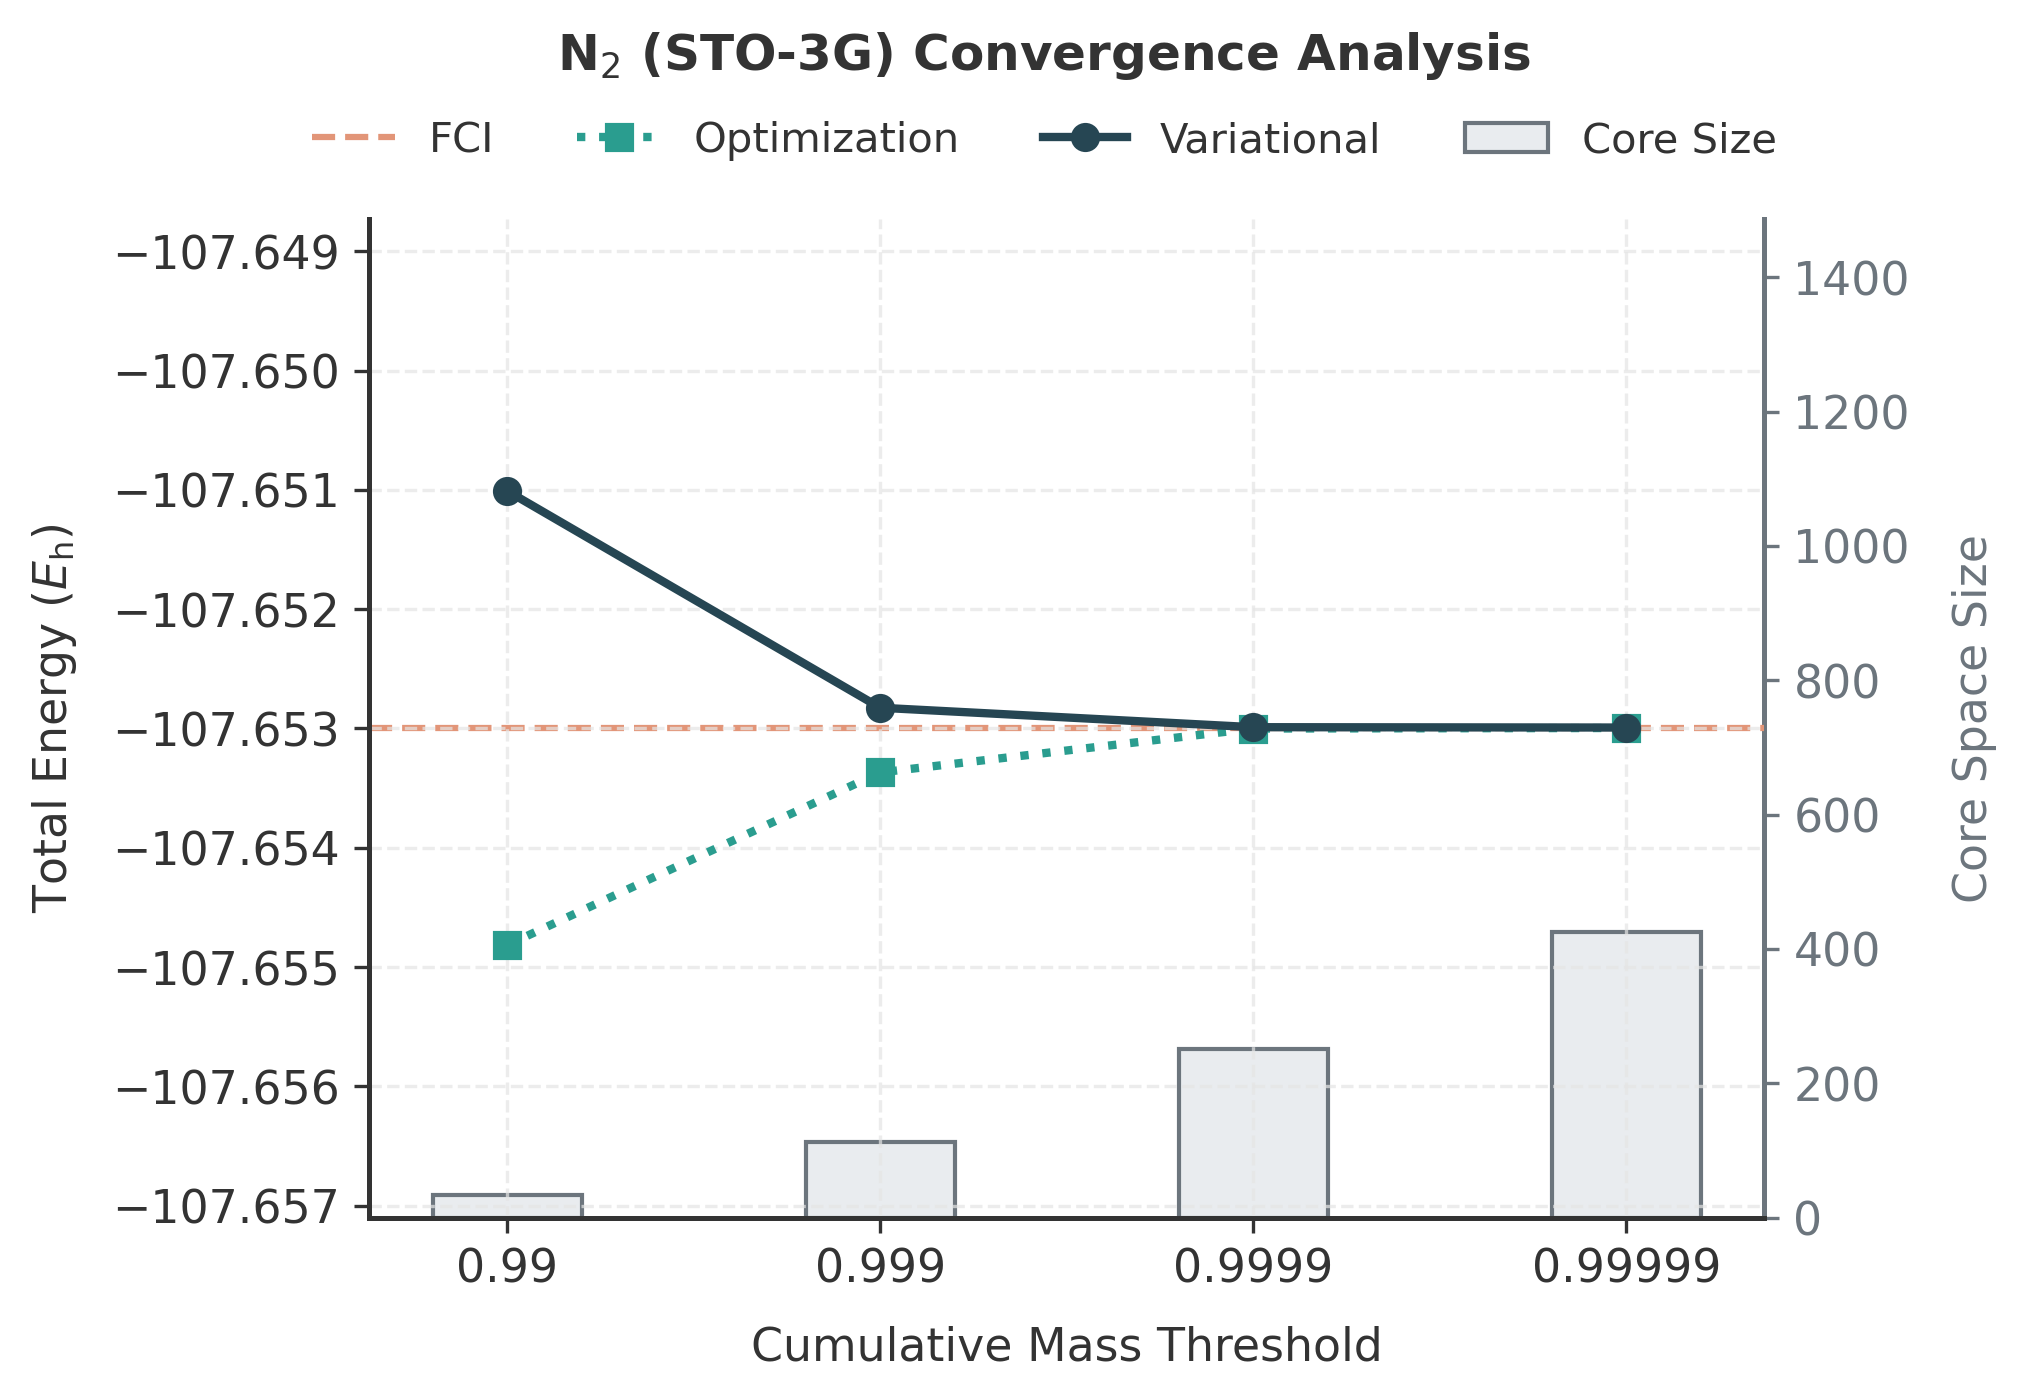

In [32]:
"""
Experiment 1: N2/STO-3G Convergence.
Dual-axis plot: Energy convergence (Lines) vs Core Space Size (Bars).
"""

def plot_n2_convergence():
    # Data preparation
    data = {
        "Mass": ["0.99", "0.999", "0.9999", "0.99999"],
        "E_Opt": [-107.65481524, -107.65336855, -107.65300058, -107.65299583],
        "E_Var": [-107.65100900, -107.65282614, -107.65298912, -107.65299202], 
        "CoreSize": [34, 113, 251, 425],
        "E_FCI": -107.65299988
    }
    df = pd.DataFrame(data)
    x_pos = range(len(df))

    # Setup figure
    fig, ax1 = plt.subplots(figsize=(6, 4.5))
    plt.subplots_adjust(top=0.85)

    # --- Right Axis: Core Size (Background Bars) ---
    ax2 = ax1.twinx()
    ax2.bar(x_pos, df["CoreSize"], color=PALETTE['bar_fill'], 
            edgecolor=PALETTE['bar_edge'], width=0.4, zorder=0, 
            label="Core Size")
    
    # Style right axis
    ax2.set_ylabel("Core Space Size", color=PALETTE['bar_edge'], labelpad=10)
    ax2.tick_params(axis='y', colors=PALETTE['bar_edge'])
    ax2.spines['right'].set_visible(True)
    ax2.spines['right'].set_color(PALETTE['bar_edge'])
    ax2.set_ylim(0, df["CoreSize"].max() * 3.5)

    # --- Left Axis: Energy (Foreground Lines) ---
    ax1.set_zorder(ax2.get_zorder() + 1)
    ax1.patch.set_visible(False) # Transparent background for overlay
    
    # Plot lines (FCI uses baseline color)
    l_ref = ax1.axhline(data["E_FCI"], color=PALETTE['baseline'], 
                        linestyle='--', linewidth=1.5, label="FCI", zorder=1)
    l_opt, = ax1.plot(x_pos, df["E_Opt"], marker='s', linestyle=':', 
                      color=PALETTE['secondary'], markersize=6, linewidth=2, 
                      label="Optimization", zorder=2)
    l_var, = ax1.plot(x_pos, df["E_Var"], marker='o', linestyle='-', 
                      color=PALETTE['primary'], markersize=6, linewidth=2, 
                      label="Variational", zorder=3)

    # Formatting
    format_axis(ax1, "Cumulative Mass Threshold", r"Total Energy ($E_{\mathrm{h}}$)")
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(df["Mass"])
    
    # Auto-scale Y-axis with margin
    e_vals = df["E_Opt"].tolist() + df["E_Var"].tolist()
    margin = (max(e_vals) - min(e_vals)) * 0.6
    ax1.set_ylim(min(e_vals) - margin, max(e_vals) + margin)

    # Combined Legend
    handles = [l_ref, l_opt, l_var, ax2.patches[0]]
    labels = ["FCI", "Optimization", "Variational", "Core Size"]
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=4)
    
    fig.suptitle(r"N$_2$ (STO-3G) Convergence Analysis", y=0.99, fontsize=12, weight='bold')
    plt.show()

plot_n2_convergence()

Computing FCI ref (14400 dets)...
k=10: sCI=-131.2082, Lowdin=-131.2646
k=50: sCI=-131.2554, Lowdin=-131.2682
k=100: sCI=-131.2643, Lowdin=-131.2683
k=150: sCI=-131.2667, Lowdin=-131.2683
k=200: sCI=-131.2674, Lowdin=-131.2683
k=400: sCI=-131.2683, Lowdin=-131.2684
k=800: sCI=-131.2684, Lowdin=-131.2684


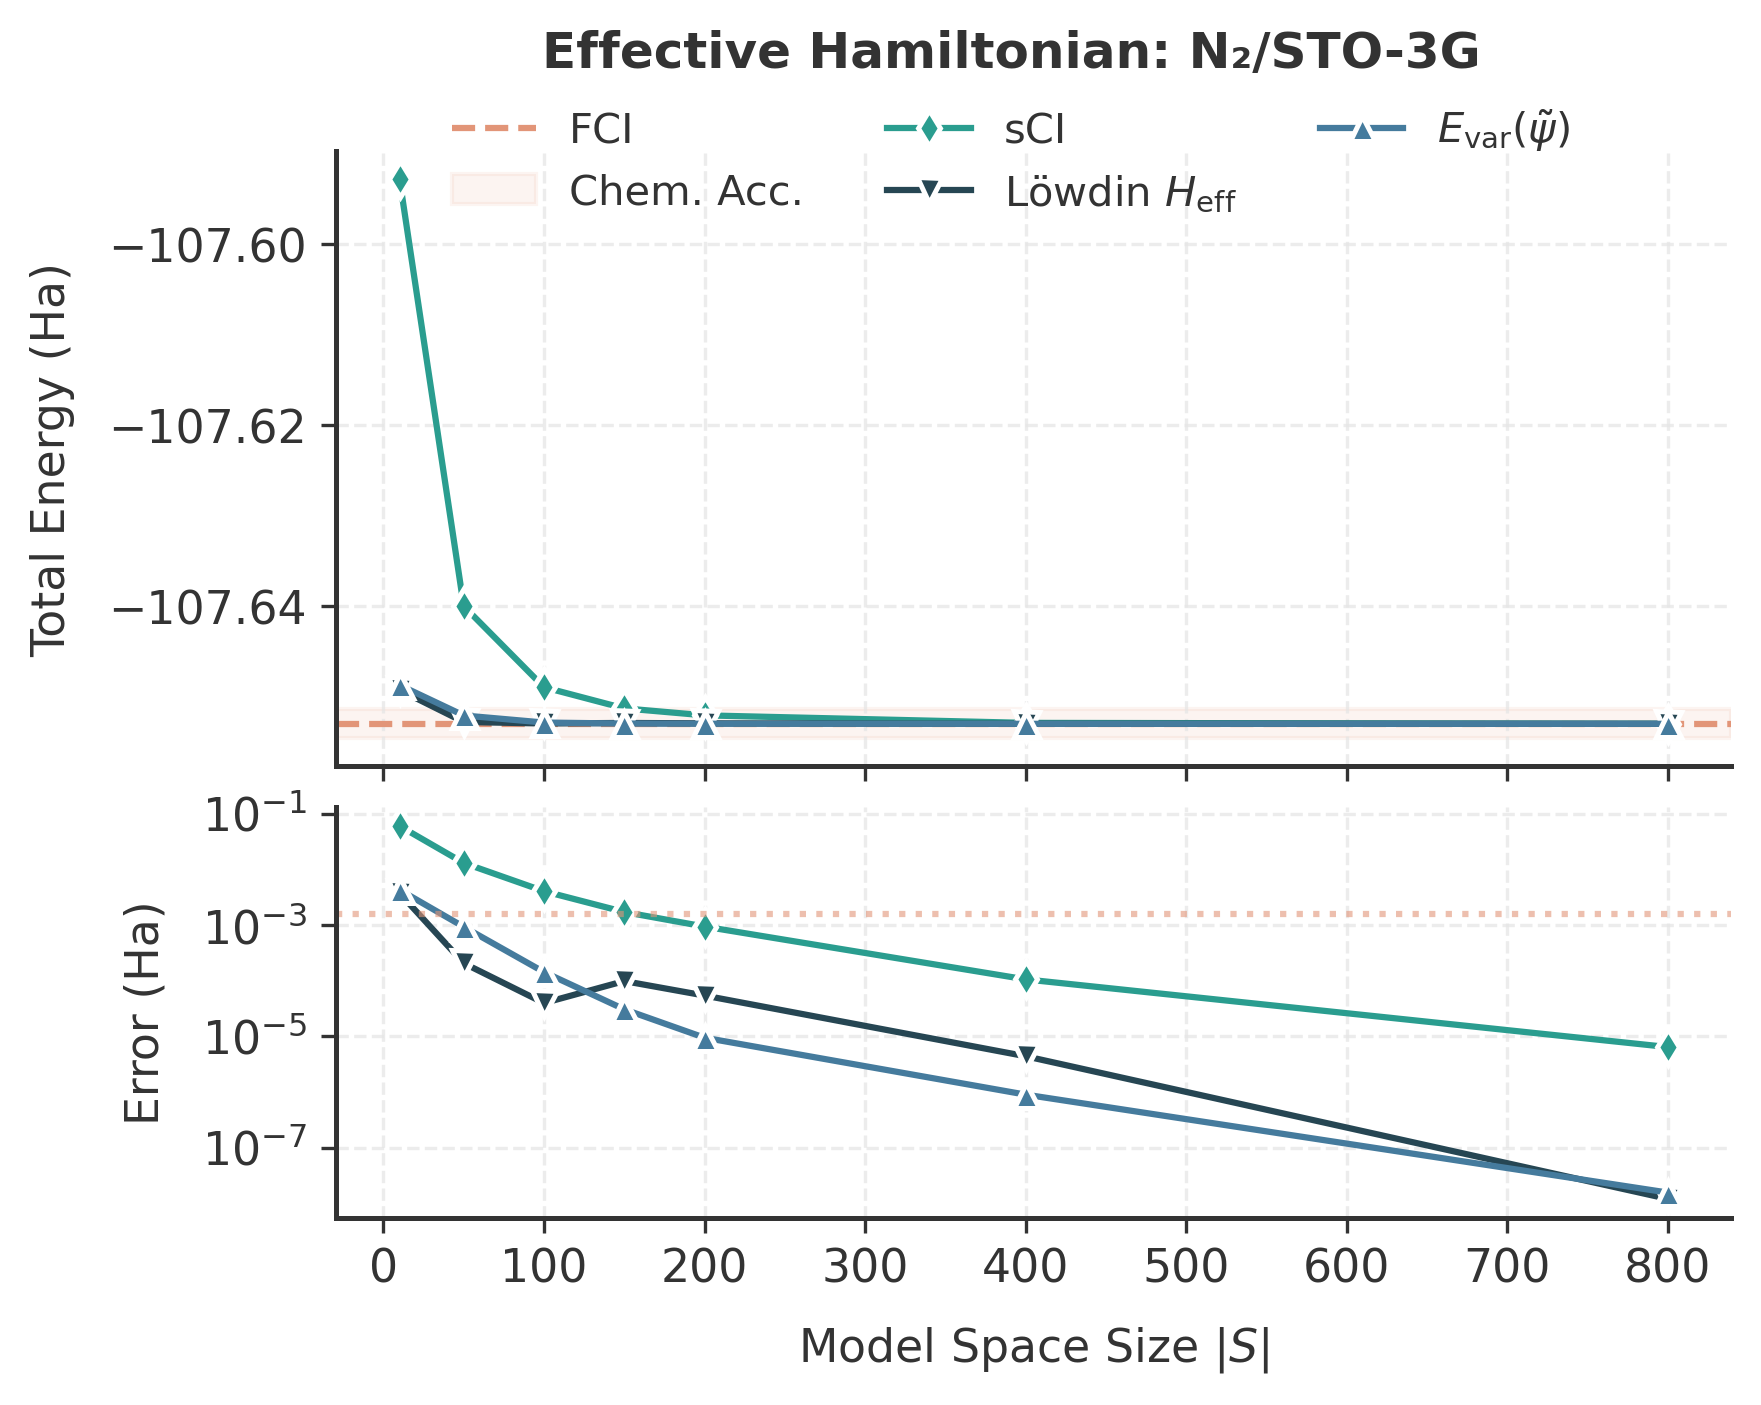

In [33]:
"""
Experiment 2: Löwdin Effective Hamiltonian.
Compares convergence of sCI, Löwdin Perturbation, and Exact Variational methods.
"""

from dataclasses import dataclass, field
from pathlib import Path
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import lever

# Simulation Config
CFG = {
    "sys_name": "N₂/STO-3G",
    "path": Path("../benchmark/FCIDUMP/N2_sto3g.FCIDUMP"),
    "n_orb": 10, "n_elec": (7, 7),
    "k_steps": [10, 50, 100, 150, 200, 400, 800],
    "eps": 1e-12
}

@dataclass
class StudyResults:
    k: list[int] = field(default_factory=list)
    E_sCI: list[float] = field(default_factory=list)
    E_Lowdin: list[float] = field(default_factory=list)
    E_Exact: list[float] = field(default_factory=list)

def solve_eigen(H):
    """Solver wrapper for dense/sparse matrices."""
    if H.shape[0] < 10:
        evals, evecs = np.linalg.eigh(H.toarray())
    else:
        evals, evecs = spla.eigsh(H, k=1, which="SA", tol=1e-15)
    return evals[0], evecs[:, 0]

def run_simulation():
    """Run convergence study (sCI vs Lowdin vs Exact)."""
    if not CFG['path'].exists(): raise FileNotFoundError("FCIDUMP missing.")
    
    # Setup System
    int_ctx = lever.IntCtx(str(CFG['path']), CFG['n_orb'])
    fci_dets = lever.gen_fci_dets(CFG['n_orb'], *CFG['n_elec'])
    E_nuc = int_ctx.get_e_nuc()
    
    # Compute FCI Reference
    print(f"Computing FCI ref ({len(fci_dets)} dets)...")
    ham_fci, _ = lever.engine.hamiltonian.get_ham_ss(fci_dets, int_ctx, CFG['n_orb'])
    E_fci, psi_fci = solve_eigen(sp.coo_matrix((ham_fci.vals, (ham_fci.rows, ham_fci.cols)), shape=ham_fci.shape).tocsr())
    
    # Sort determinants by weight
    ranking = np.argsort(-np.abs(psi_fci))
    results = StudyResults()
    
    # Loop over model space sizes
    for k in [k for k in CFG['k_steps'] if k <= len(fci_dets)]:
        S_dets = fci_dets[ranking[:k]]
        ham_ss, ham_sc, space = lever.get_ham_proxy(S_dets, int_ctx, CFG['n_orb'], mode="none")
        
        # 1. sCI
        H_ss_csr = sp.coo_matrix((ham_ss.vals, (ham_ss.rows, ham_ss.cols)), shape=ham_ss.shape).tocsr()
        E_sCI, _ = solve_eigen(H_ss_csr)
        
        # 2. Lowdin
        ham_eff = lever.engine.hamiltonian.get_ham_eff(ham_ss, ham_sc, space.h_diag_c, E_sCI, "sigma", CFG['eps'], True)
        H_eff_csr = sp.coo_matrix((ham_eff.vals, (ham_eff.rows, ham_eff.cols)), shape=ham_eff.shape).tocsr()
        E_Lowdin, _ = solve_eigen(H_eff_csr)
        
        # 3. Exact T-space
        H_sc_csr = sp.coo_matrix((ham_sc.vals, (ham_sc.rows, ham_sc.cols)), shape=ham_sc.shape).tocsr()
        H_tilde = sp.bmat([[H_ss_csr, H_sc_csr], [H_sc_csr.T.conj(), sp.diags(space.h_diag_c)]], format="csr")
        E_exact_val, psi_tilde = solve_eigen(H_tilde)
        
        # Compute true expectation <psi|H|psi>
        T_dets = np.vstack([space.s_dets, space.c_dets])
        ham_tt, _ = lever.engine.hamiltonian.get_ham_ss(T_dets, int_ctx, CFG['n_orb'])
        H_TT = sp.coo_matrix((ham_tt.vals, (ham_tt.rows, ham_tt.cols)), shape=ham_tt.shape).tocsr()
        E_exact = np.real(np.vdot(psi_tilde, H_TT @ psi_tilde) / np.vdot(psi_tilde, psi_tilde))

        results.E_sCI.append(E_sCI + E_nuc)
        results.E_Lowdin.append(E_Lowdin + E_nuc)
        results.E_Exact.append(E_exact + E_nuc)
        results.k.append(k)
        print(f"k={k}: sCI={E_sCI:.4f}, Lowdin={E_Lowdin:.4f}")

    return results, E_fci + E_nuc

def plot_study(res, e_fci):
    """Generate dual-panel convergence plot."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4.5), sharex=True, height_ratios=[3, 2])
    plt.subplots_adjust(top=0.9, hspace=0.08)
    
    style = {'markersize': 6, 'linewidth': 1.5, 'markeredgecolor': 'white', 'markeredgewidth': 1.2}
    
    # Panel 1: Absolute Energies
    ax1.axhspan(e_fci - 1.6e-3, e_fci + 1.6e-3, color=PALETTE['baseline'], alpha=0.1, label="Chem. Acc.")
    ax1.axhline(e_fci, color=PALETTE['baseline'], linestyle='--', label="FCI")
    
    ax1.plot(res.k, res.E_sCI, marker='d', color=PALETTE['secondary'], label="sCI", **style)
    ax1.plot(res.k, res.E_Lowdin, marker='v', color=PALETTE['primary'], label=r"Löwdin $H_{\mathrm{eff}}$", **style)
    ax1.plot(res.k, res.E_Exact, marker='^', color=PALETTE['accent'], label=r"$E_{\mathrm{var}}(\tilde{\psi})$", **style)
    format_axis(ax1, ylabel="Total Energy (Ha)")
    
    # Panel 2: Log Errors
    for y, c, m in [(res.E_sCI, PALETTE['secondary'], 'd'), 
                    (res.E_Lowdin, PALETTE['primary'], 'v'), 
                    (res.E_Exact, PALETTE['accent'], '^')]:
        ax2.semilogy(res.k, np.abs(np.array(y) - e_fci), marker=m, color=c, **style)
        
    ax2.axhline(1.6e-3, color=PALETTE['baseline'], linestyle=':', alpha=0.6)
    format_axis(ax2, xlabel=r"Model Space Size $|S|$", ylabel="Error (Ha)", log_scale=True)
    
    # Legend & Title
    h, l = ax1.get_legend_handles_labels()
    order = [1, 0, 2, 3, 4] # Reorder for clarity
    fig.legend([h[i] for i in order], [l[i] for i in order], loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=3)
    fig.suptitle(f"Effective Hamiltonian: {CFG['sys_name']}", y=0.99, fontsize=12, weight='bold')
    plt.show()

# Run
if __name__ == "__main__":
    results, e_ref = run_simulation()
    plot_study(results, e_ref)

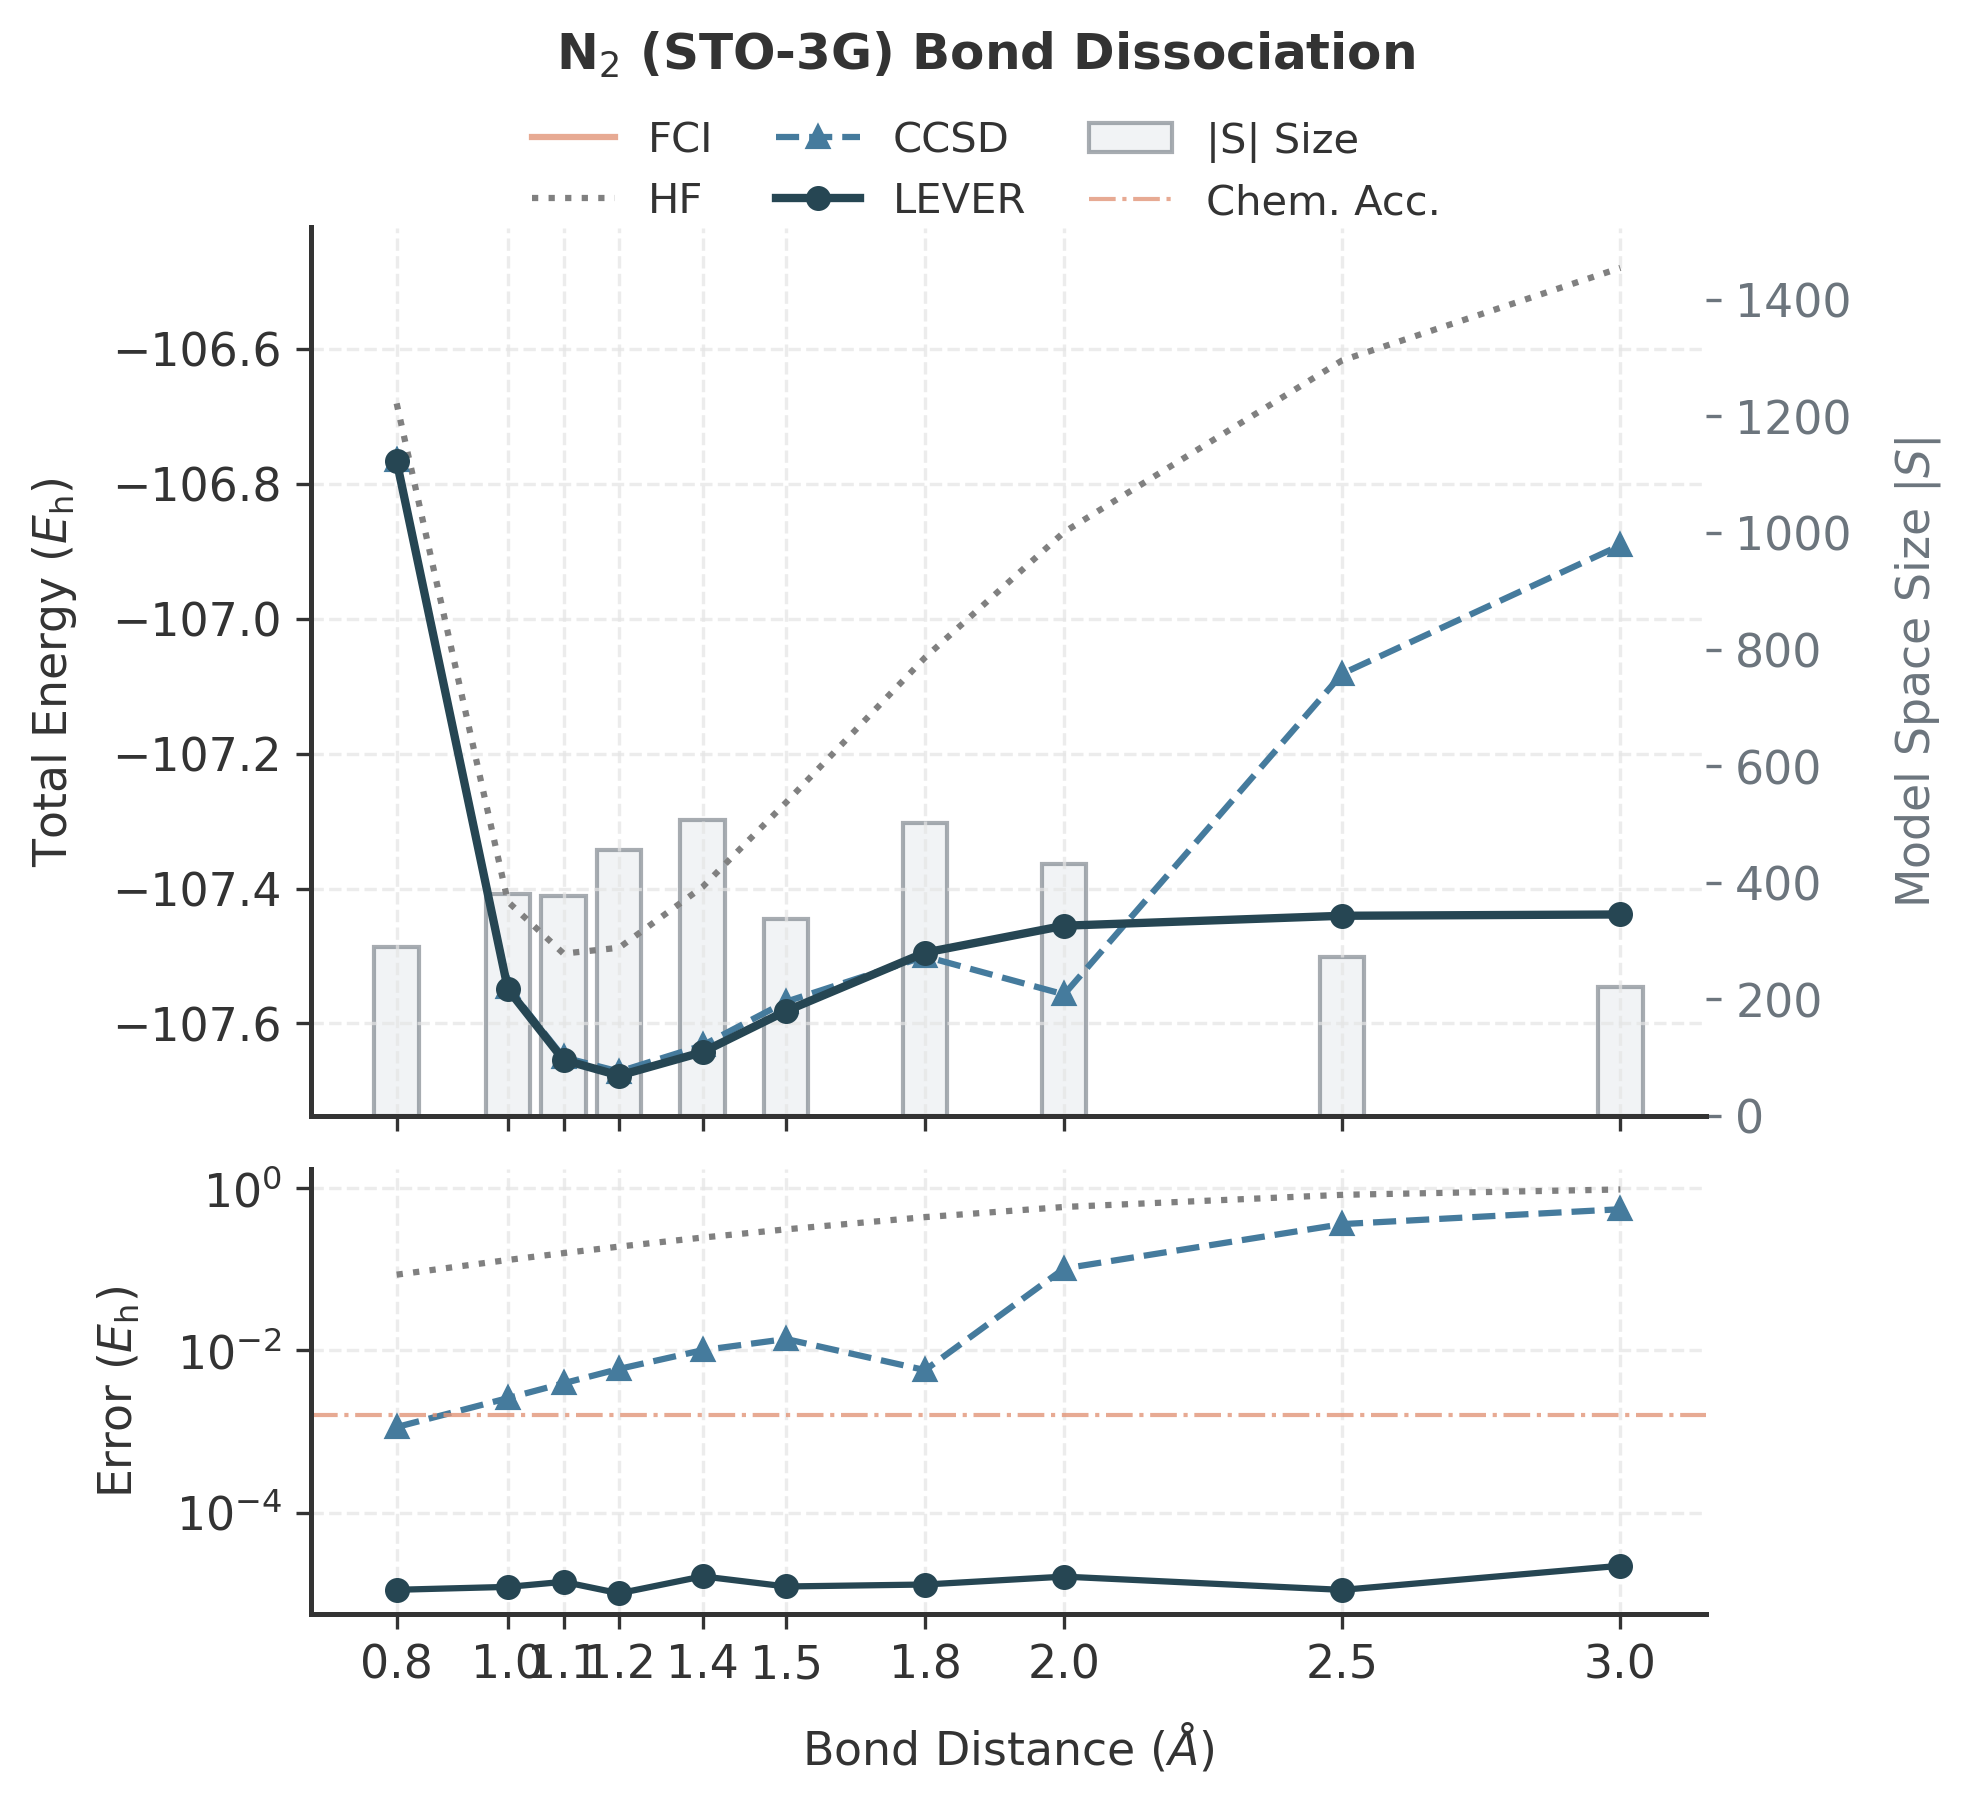

In [34]:
"""
Experiment 3: N2 Bond Dissociation PES.
Panel 1: Absolute energies and Model Space Size.
Panel 2: Log-scale error relative to FCI baseline.
"""

CSV_PATH = Path("scan_results.csv")

def plot_pes_scan(csv_path: Path):
    if not csv_path.exists():
        print(f"Skipping PES plot: {csv_path} not found.")
        return

    df = pd.read_csv(csv_path).sort_values("dist")
    
    # Setup: 2 panels, shared X
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, 
                                   gridspec_kw={'height_ratios': [2, 1]})
    plt.subplots_adjust(hspace=0.08, top=0.88)

    # --- Panel 1: Energies & Space Size ---
    
    # Background Bars (Right Axis)
    ax1_r = ax1.twinx()
    bars = ax1_r.bar(df['dist'], df['n_s'], color=PALETTE['bar_fill'], 
                     edgecolor=PALETTE['bar_edge'], width=0.08, 
                     label="|S| Size", zorder=0, alpha=0.6)
    
    ax1_r.set_ylabel("Model Space Size $|S|$", color=PALETTE['bar_edge'], labelpad=10)
    ax1_r.tick_params(axis='y', colors=PALETTE['bar_edge'])
    ax1_r.spines['right'].set_color(PALETTE['bar_edge'])
    ax1_r.set_ylim(0, df['n_s'].max() * 3.0)

    # Foreground Lines (Left Axis)
    ax1.set_zorder(ax1_r.get_zorder() + 1)
    ax1.patch.set_visible(False)

    l_hf, = ax1.plot(df['dist'], df['E_HF'], color='gray', linestyle=':', 
                     label="HF", linewidth=1.5)
    l_ccsd, = ax1.plot(df['dist'], df['E_CCSD'], color=PALETTE['accent'], 
                       marker='^', markersize=5, linestyle='--', label="CCSD")
    # FCI uses baseline color
    l_fci, = ax1.plot(df['dist'], df['E_FCI'], color=PALETTE['baseline'], alpha=0.8,
                      linestyle='-', linewidth=1.5, label="FCI (Ref)")
    l_lev, = ax1.plot(df['dist'], df['E_LEVER'], color=PALETTE['primary'], 
                        marker='o', markersize=5, linestyle='-', 
                        linewidth=2, label="LEVER")

    format_axis(ax1, ylabel=r"Total Energy ($E_{\mathrm{h}}$)")

    # --- Panel 2: Errors (Log Scale) ---
    err_hf = np.abs(df['E_HF'] - df['E_FCI'])
    err_ccsd = np.abs(df['E_CCSD'] - df['E_FCI'])
    err_lev = np.abs(df['E_LEVER'] - df['E_FCI'])
    
    ax2.semilogy(df['dist'], err_hf, color='gray', linestyle=':', linewidth=1.5)
    ax2.semilogy(df['dist'], err_ccsd, color=PALETTE['accent'], marker='^', markersize=5, linestyle='--')
    ax2.semilogy(df['dist'], err_lev, color=PALETTE['primary'], marker='o', markersize=5, linestyle='-')
    
    l_chem = ax2.axhline(1.6e-3, color=PALETTE['baseline'], linestyle='-.', 
                         linewidth=1, alpha=0.8, label="Chem. Acc.")

    format_axis(ax2, xlabel=r"Bond Distance ($\AA$)", ylabel=r"Error ($E_{\mathrm{h}}$)", log_scale=True)
    ax2.set_xticks(df['dist'])
    ax2.set_xticklabels([f"{x:.1f}" for x in df['dist']])

    # --- Legend ---
    handles = [l_fci, l_hf, l_ccsd, l_lev, bars, l_chem]
    labels = ["FCI", "HF", "CCSD", "LEVER", "|S| Size", "Chem. Acc."]
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=3, columnspacing=1.5)
    fig.suptitle(r"N$_2$ (STO-3G) Bond Dissociation", y=0.99, fontsize=12, weight='bold')
    plt.show()

plot_pes_scan(CSV_PATH)

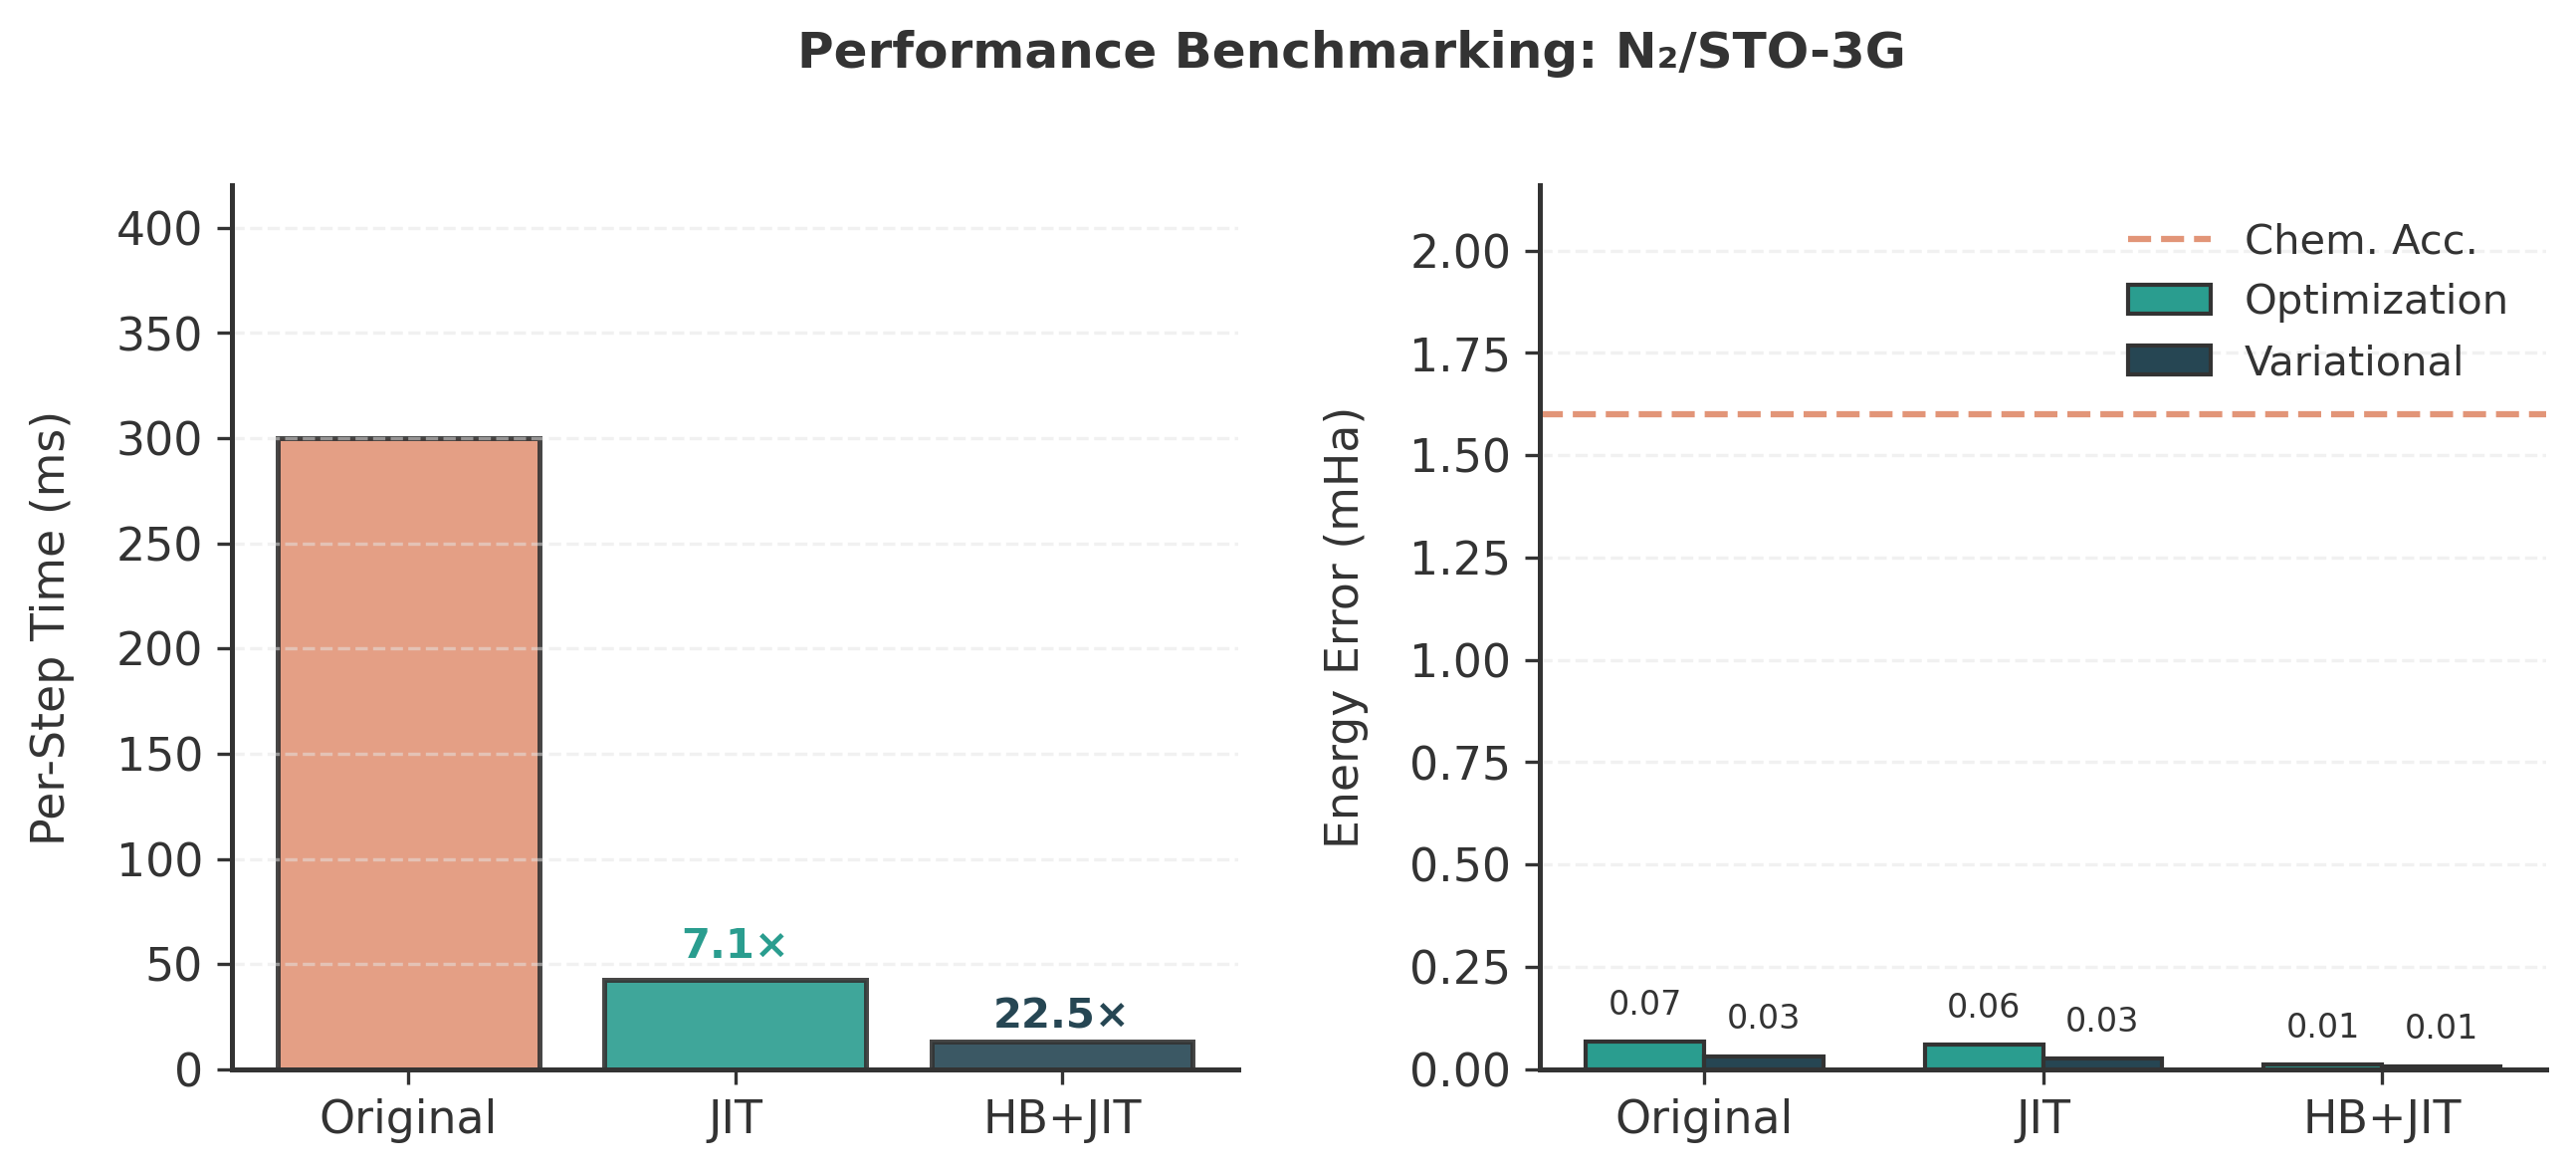

In [36]:
"""
Experiment 4: Performance Optimization.
Panel 1: Runtime speedup.
Panel 2: Energy accuracy relative to FCI.
"""

def plot_performance():
    # Benchmark Data (Mass=0.999)
    data = {
        "Method": ["Original", "JIT", "HB+JIT"],
        "Time": [0.30024, 0.04249, 0.01335], # Seconds
        "E_Opt": [-107.6601395, -107.6601468, -107.660218],
        "E_Var": [-107.6601746, -107.6601811, -107.6601988],
        "E_FCI": -107.6602064
    }
    df = pd.DataFrame(data)
    speedup = df["Time"].iloc[0] / df["Time"]
    
    # Setup
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    plt.subplots_adjust(top=0.85, wspace=0.3)
    x = np.arange(len(df))
    
    # --- Panel 1: Runtime (ms) ---
    # Colors represent optimization level
    colors = [PALETTE['baseline'], PALETTE['secondary'], PALETTE['primary']]
    bars = ax1.bar(x, df["Time"]*1000, color=colors, edgecolor=PALETTE['text'], 
                   linewidth=1.2, alpha=0.9, label="Time (ms)")
    
    # Annotate Speedup
    for i, (bar, sp) in enumerate(zip(bars, speedup)):
        if i > 0:
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height()*1.15, 
                     f'{sp:.1f}×', ha='center', va='bottom', 
                     fontsize=10, weight='bold', color=colors[i])

    ax1.set_ylabel("Per-Step Time (ms)", fontweight='medium', labelpad=10)
    ax1.set_ylim(0, df["Time"].max()*1000 * 1.4)
    ax1.set_xticks(x)
    ax1.set_xticklabels(df["Method"])
    ax1.grid(True, axis='y', alpha=0.5, zorder=0)

    # --- Panel 2: Accuracy (mHa) ---
    E_fci = df["E_FCI"].iloc[0]
    err_opt = np.abs(df["E_Opt"] - E_fci) * 1000
    err_var = np.abs(df["E_Var"] - E_fci) * 1000
    
    w = 0.35
    b1 = ax2.bar(x - w/2, err_opt, w, color=PALETTE['secondary'], edgecolor=PALETTE['text'], label="Optimization")
    b2 = ax2.bar(x + w/2, err_var, w, color=PALETTE['primary'], edgecolor=PALETTE['text'], label="Variational")
    
    # Chemical Accuracy Line (Baseline Color)
    ax2.axhline(1.6, color=PALETTE['baseline'], linestyle='--', linewidth=1.5, label="Chem. Acc.", zorder=1)
    
    ax2.set_ylabel("Energy Error (mHa)", fontweight='medium', labelpad=10)
    ax2.set_xticks(x)
    ax2.set_xticklabels(df["Method"])
    ax2.legend(loc='upper right', framealpha=0.95)
    ax2.grid(True, axis='y', alpha=0.5, zorder=0)
    ax2.set_ylim(0, max(err_opt.max(), 1.6) * 1.35)

    # Annotate values
    for group in [b1, b2]:
        for b in group:
            ax2.text(b.get_x() + b.get_width()/2, b.get_height() + 0.05, 
                     f'{b.get_height():.2f}', ha='center', va='bottom', fontsize=8)

    fig.suptitle("Performance Benchmarking: N₂/STO-3G", fontsize=12, weight='bold', y=0.98)
    plt.show()

plot_performance()